# Modeling

In [1]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/TTKS 20203/VIB/Track 1 Datarathon/'
%cd $path
!ls

Mounted at /content/drive
/content/drive/MyDrive/TTKS 20203/VIB/Track 1 Datarathon
'0.Data VIB Hackathon Guidline.xlsx'   5.Data_Lending.csv   log.csv
 1.Data_Customer.csv		       6.Data_Card.csv	    logs.csv
 2.Data_MyVIB_Transaction.csv	       feature.csv	    members.csv
 3.Data_MyVIB_Activity.csv	       feature_new.csv	    tran.csv
 3.Data_MyVIB_Activity_New	       features.txt	    trans.csv
 4.Data_Deposit.csv		       label_times.csv


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
features = pd.read_csv(path+'feature_new.csv')

In [4]:
feature = features.copy()
feature['CUTOFF_TIME'] = pd.to_datetime(feature['CUTOFF_TIME'])
feature = feature.sort_values(['CUSTOMER_NUMBER', 'CUTOFF_TIME'])
feature.shape

(227763, 90)

In [5]:
to_drop =[column for column in feature.columns if (feature[column] == 0).all()]
print(to_drop)
feature.drop(columns=to_drop, inplace=True)
feature.shape

['EB_REGISTER_CHANNEL_3', 'VERIFY_METHOD_3']


(227763, 88)

In [6]:
[column for column in feature.columns if (feature[column]).is_unique]        

[]

In [7]:
threshold = 0.95

corr_matrix = feature.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
to_drop

['CLIENT_SEX_1',
 'STAFF_VIB_1',
 'SMS_1',
 'VERIFY_METHOD_2',
 'ALL_ACTIVITY_NAME_1',
 'ALL_ACTIVITY_NAME_4',
 'ALL_TRANS_LV1_VEC_0',
 'ALL_TRANS_LV2_VEC_0',
 'ALL_TRANS_LV2_VEC_3']

In [8]:
to_drop = ['CLIENT_SEX_1','STAFF_VIB_1','SMS_1']

feature.drop(columns=to_drop, inplace=True)
feature.shape

(227763, 85)

In [9]:
feature.head()

,CUSTOMER_NUMBER,AGE_AT_CREATE,CREATE_TO_IB_REGISTER,CUTOFF_TIME,LABEL,DAYS_TO_CHURN,CHURN_DATE,SUM_ACTIVITY_DATE,SUM_ACTIVITY_NO,SUM_ACTIVE_ON_APP,SUM_TRANS_DATE,SUM_TRANS_NO,SUM_TRANS_AMOUNT,SUM_TRANS_PER_DAY,CLIENT_SEX_0,STAFF_VIB_0,EB_REGISTER_CHANNEL_0,EB_REGISTER_CHANNEL_1,EB_REGISTER_CHANNEL_2,SMS_0,VERIFY_METHOD_0,VERIFY_METHOD_1,VERIFY_METHOD_2,ALL_ACTIVITY_NAME_0,ALL_ACTIVITY_NAME_1,ALL_ACTIVITY_NAME_2,ALL_ACTIVITY_NAME_3,ALL_ACTIVITY_NAME_4,ALL_ACTIVITY_NAME_5,ALL_ACTIVITY_NAME_6,ALL_ACTIVITY_NAME_7,ALL_ACTIVITY_NAME_8,ALL_ACTIVITY_NAME_9,ALL_ACTIVITY_NAME_10,ALL_ACTIVITY_NAME_11,ALL_ACTIVITY_NAME_12,ALL_ACTIVITY_NAME_13,ALL_ACTIVITY_NAME_14,ALL_ACTIVITY_NAME_15,ALL_ACTIVITY_NAME_16,...,ALL_ACTIVITY_NAME_22,ALL_ACTIVITY_NAME_23,ALL_ACTIVITY_NAME_24,ALL_ACTIVITY_NAME_25,ALL_ACTIVITY_NAME_26,ALL_ACTIVITY_NAME_27,ALL_ACTIVITY_NAME_28,ALL_ACTIVITY_NAME_29,ALL_ACTIVITY_NAME_30,ALL_ACTIVITY_NAME_31,ALL_ACTIVITY_NAME_32,ALL_ACTIVITY_NAME_33,ALL_ACTIVITY_NAME_34,ALL_ACTIVITY_NAME_35,ALL_ACTIVITY_NAME_36,ALL_ACTIVITY_NAME_37,ALL_ACTIVITY_NAME_38,ALL_ACTIVITY_NAME_39,ALL_ACTIVITY_NAME_40,ALL_ACTIVITY_NAME_41,ALL_ACTIVITY_NAME_42,ALL_ACTIVITY_NAME_43,ALL_ACTIVITY_NAME_44,ALL_TRANS_LV1_VEC_0,ALL_TRANS_LV1_VEC_1,ALL_TRANS_LV1_VEC_2,ALL_TRANS_LV2_VEC_0,ALL_TRANS_LV2_VEC_1,ALL_TRANS_LV2_VEC_2,ALL_TRANS_LV2_VEC_3,ALL_TRANS_LV2_VEC_4,ALL_TRANS_LV2_VEC_5,ALL_TRANS_LV2_VEC_6,ALL_TRANS_LV2_VEC_7,ALL_TRANS_LV2_VEC_8,ALL_TRANS_LV2_VEC_9,ALL_TRANS_LV2_VEC_10,ALL_TRANS_LV2_VEC_11,ALL_TRANS_LV2_VEC_12,ALL_TRANS_LV2_VEC_13
0,0,11301.0,2.0,2019-10-01,1.0,44.0,2019-11-14,1,10,1,1,1,99800000,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,11301.0,2.0,2019-11-01,0.0,13.0,NaN,5,39,6,2,2,101800000,2,1,1,0,1,0,1,0,1,0,3,5,3,2,5,1,0,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,11301.0,2.0,2019-12-01,0.0,NaN,NaN,7,77,11,4,5,177800000,4,1,1,0,1,0,1,0,1,0,5,9,6,4,9,1,0,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,11301.0,2.0,2020-01-01,0.0,NaN,NaN,12,112,18,9,11,249819000,10,1,1,0,1,0,1,0,1,0,8,16,7,4,16,1,0,1,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0
23,9,13683.0,2.0,2020-01-01,0.0,NaN,NaN,34,619,52,6,6,11694976,6,0,1,0,1,0,0,0,1,0,38,41,36,21,40,1,1,2,1,1,1,0,3,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,3,2,0,0,0,3,0,0,1,0,0,0,0,0,0


In [12]:
missing_pct = feature.isnull().sum() / len(feature)
to_drop = list((missing_pct[missing_pct > 0.9]).index)
to_drop = [x for x in to_drop if x not in ['DAYS_TO_CHURN','CHURN_DATE']]
to_drop

[]

# Separate into Training and Testing Set

In [14]:
feature['CUTOFF_TIME'].describe()

count                  227763
unique                     12
top       2020-01-01 00:00:00
freq                    45933
first     2019-02-01 00:00:00
last      2020-01-01 00:00:00
Name: CUTOFF_TIME, dtype: object

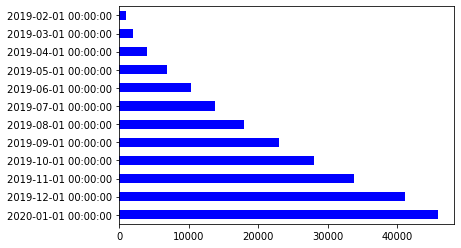

In [15]:
feature['CUTOFF_TIME'].value_counts().plot.barh(color = 'b')

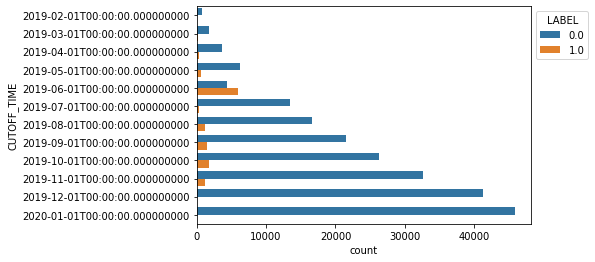

In [16]:
p = sns.countplot(data=feature.sort_values(by='CUTOFF_TIME'), y='CUTOFF_TIME', hue='LABEL')
p.legend(title='LABEL', bbox_to_anchor=(1, 1), loc='upper left')

In [69]:
# X_train, X_test = train_test_split(feature, test_size=0.2,random_state = 1)

In [143]:
feature = feature[feature['CUTOFF_TIME']<='2019-11-01']
split_date = pd.datetime(2019, 10, 1)

train = feature.loc[feature['CUTOFF_TIME'] <= split_date].copy()
test = feature.loc[feature['CUTOFF_TIME'] > split_date].copy()

train.sort_values(['CUTOFF_TIME'], inplace=True)
test.sort_values(['CUTOFF_TIME'], inplace=True)
train.shape, test.shape, len(train) / len(feature)

((106784, 85), (33822, 85), 0.7594554997653016)

# Feature Preparation

There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [144]:
train = train.drop(columns=['CUTOFF_TIME', 'CUSTOMER_NUMBER', 'CHURN_DATE'])
test = test.drop(columns=['CUTOFF_TIME', 'CUSTOMER_NUMBER', 'CHURN_DATE'])

In [145]:
y, test_y = np.array(train.pop('LABEL')), np.array(test.pop('LABEL'))

y_reg, test_y_reg = np.array(train.pop('DAYS_TO_CHURN')), np.array(
    test.pop('DAYS_TO_CHURN'))

In [146]:
# scale = StandardScaler().fit(train)
# train = scale.transform(train)
# test = scale.transform(test)

Text(0, 0.5, 'Count')

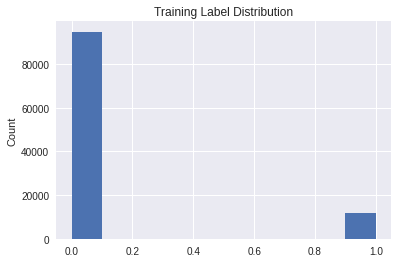

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y)
plt.title('Training Label Distribution')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

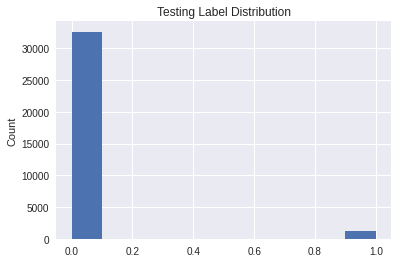

In [148]:
plt.hist(test_y)
plt.title('Testing Label Distribution')
plt.ylabel('Count')

-> Imbalanced classification problem

# Machine Learning

In [149]:
np.random.seed(50)
naive_guess = np.random.binomial(1, p=np.mean(y), size=len(test_y))
naive_guess[:10], naive_guess.sum()

(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 3705)

In [150]:
from sklearn.metrics import (roc_auc_score, precision_score,
                             recall_score, f1_score)

print(f'Naive Baseline\n')
roc = roc_auc_score(test_y, np.repeat(np.mean(y), len(test_y)))
print(f'ROC AUC: {round(roc, 4)}')

for metric in [precision_score, recall_score, f1_score]:
    print(f'{metric.__name__}: {round(metric(test_y, naive_guess), 4)}')

Naive Baseline

ROC AUC: 0.5
precision_score: 0.0345
recall_score: 0.1052
f1_score: 0.052


In [151]:
print(f'The percentage of churns is {100 * round(np.mean(y), 4)}% in the training data.')

The percentage of churns is 11.15% in the training data.


In [152]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=50)

In [153]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):

    model.fit(train, y)

    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    for metric in [precision_score, recall_score, f1_score]:
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds


model, preds = evaluate(model, train, y, test, test_y)

LogisticRegression

ROC AUC: 0.4713
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [154]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf=50,
                               n_jobs=-1,
                               random_state=50)

model, preds = evaluate(model, train, y, test, test_y)

RandomForestClassifier

ROC AUC: 0.6886
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Model Validation

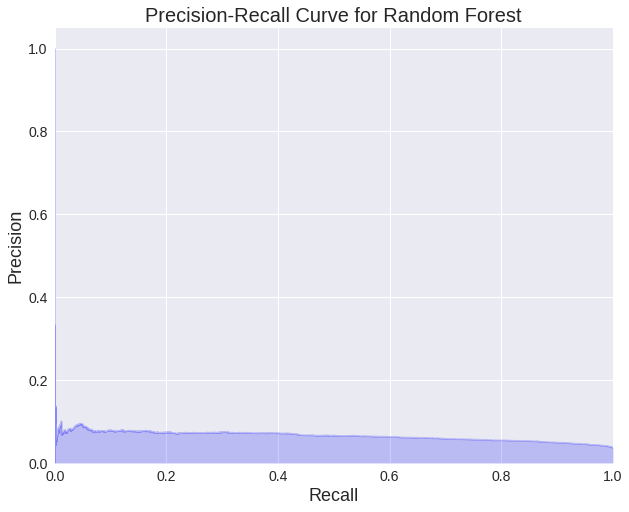

In [155]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')


def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 8))
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=18)
    plt.ylabel('Precision', size=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=20)
    plt.xticks(size=14)
    plt.yticks(size=14)

    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker='*', size=200)
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr


probs = model.predict_proba(test)[:, 1]
pr_data = plot_precision_recall(test_y, probs, title='Precision-Recall Curve for Random Forest')

In [156]:
precision_above = pr_data.copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

,precision,recall,threshold
0,0.036539,1.000000,0.007679
154,0.036678,0.999178,0.008698
156,0.036681,0.999178,0.008703
157,0.036682,0.999178,0.008709
158,0.036683,0.999178,0.008712


In [157]:
recall_attained = 0.75
recall_above = pr_data.loc[pr_data['recall'] >= recall_attained].copy()
recall_above.sort_values('precision', ascending=False, inplace=True)
recall_above.head()

,precision,recall,threshold
17048,0.056154,0.750205,0.095175
17047,0.056150,0.750205,0.095170
17046,0.056147,0.750205,0.095168
17045,0.056143,0.750205,0.095165
17044,0.056140,0.750205,0.095163


In [158]:
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

print(
    f'At a threshold of {round(threshold_required, 4)} the recall is {100 * recall_attained:.2f}% and the precision is {round(100 * precision_attained, 4)}%')

At a threshold of 0.0952 the recall is 75.00% and the precision is 5.6154%


In [160]:
def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 10))
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=24)
    plt.ylabel('Precision', size=24)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

    if threshold_selected:
        p = precision[np.where(threshold == threshold_selected)[0]]
        r = recall[np.where(threshold == threshold_selected)[0]]
        plt.scatter(r, p, marker='*', s=600, c='r')
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')
        plt.text(r - 0.1, p + 0.15,
                 s=f'Threshold: {round(threshold_selected, 2)}', size=20, fontdict={'weight': 1000})
        plt.text(r - 0.2, p + 0.075,
                 s=f'Precision: {round(100 * p[0], 2)}% Recall: {round(100 * r[0], 2)}%', size=20,
                 fontdict={'weight': 1000})

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr

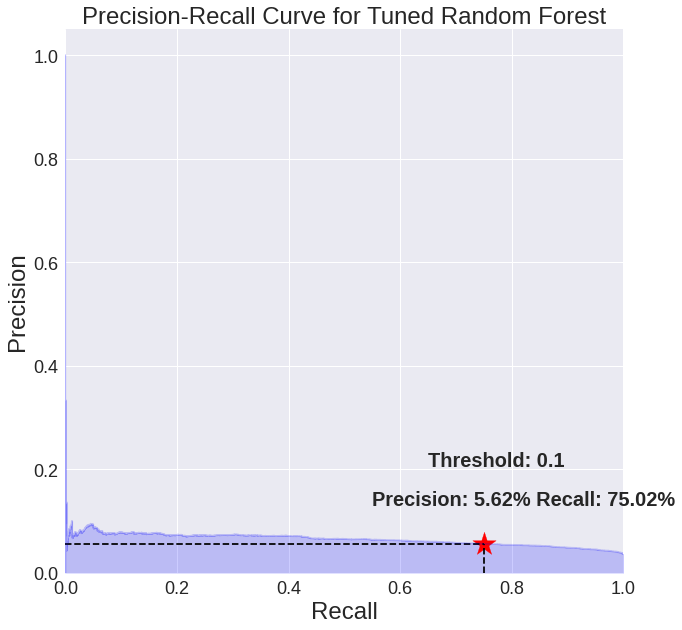

In [161]:
pr_data = plot_precision_recall(test_y, probs, title='Precision-Recall Curve for Tuned Random Forest',
                                threshold_selected=threshold_required)

#Confusion Matrix

In [162]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('bmh')
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=20)
    plt.grid(None)
    plt.ylabel('True label', size=22)
    plt.xlabel('Predicted label', size=22)
    plt.tight_layout()

Confusion matrix, without normalization
[[17259 15346]
 [  304   913]]


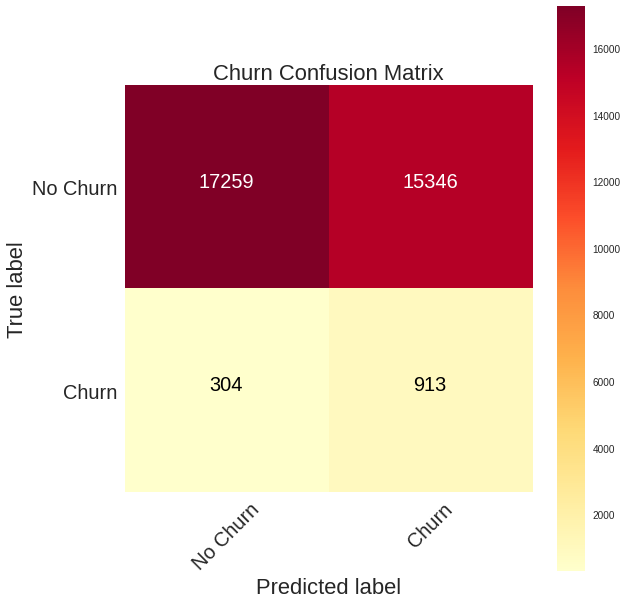

In [163]:
preds = np.zeros(len(test_y))
preds[probs >= threshold_required] = 1

cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

#Feature Importances

In [164]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head(20)

,importance
SUM_ACTIVITY_NO,0.068948
SUM_TRANS_PER_DAY,0.054284
SUM_TRANS_AMOUNT,0.052883
SUM_TRANS_DATE,0.049071
AGE_AT_CREATE,0.048250
ALL_ACTIVITY_NAME_1,0.047946
SUM_ACTIVE_ON_APP,0.047029
ALL_ACTIVITY_NAME_4,0.045824
SUM_ACTIVITY_DATE,0.044068
SUM_TRANS_NO,0.043841


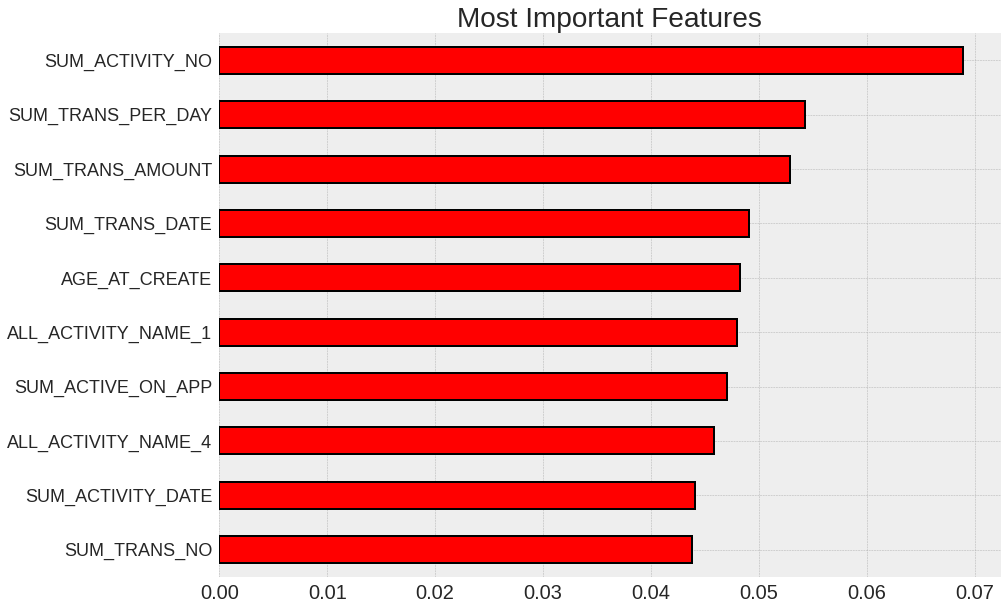

In [165]:
fi.iloc[:10]['importance'].plot.barh(color='r', edgecolor='k',
                                     figsize=(14, 10), linewidth=2)
ax = plt.gca()
ax.invert_yaxis()
plt.xticks(size=20)
plt.yticks(size=18)
plt.title('Most Important Features', size=28);

#Make Predictions

In [166]:
new_probs = model.predict_proba(test)[:, 1]

oos_ids = list(feature.loc[feature['CUTOFF_TIME'] > split_date, 'CUSTOMER_NUMBER'])
oos_cutoff_time = list(feature.loc[feature['CUTOFF_TIME'] > split_date, 'CUTOFF_TIME'])
prediction_df = pd.DataFrame({'CUSTOMER_NUMBER': oos_ids, 'CUTOFF_TIME': oos_cutoff_time, 'PROBABILITY': new_probs})
prediction_df['PREDICTION'] = prediction_df['PROBABILITY'] > threshold_required
prediction_df.sample(10)

,CUSTOMER_NUMBER,CUTOFF_TIME,PROBABILITY,PREDICTION
6436,191181,2019-11-01,0.123764,True
25492,754003,2019-11-01,0.044084,False
23131,682859,2019-11-01,0.133386,True
30252,894002,2019-11-01,0.095596,True
24349,719666,2019-11-01,0.107820,True
33578,993110,2019-11-01,0.141646,True
2809,82999,2019-11-01,0.174944,True
26841,794946,2019-11-01,0.025751,False
15033,446184,2019-11-01,0.035507,False
33274,983978,2019-11-01,0.032890,False


In [167]:
# new_probs = model.predict_proba(test)[:, 1]

# oos_ids = list(X_test['CUSTOMER_NUMBER'])
# oos_cutoff_time = list(X_test['CUTOFF_TIME'])
# prediction_df = pd.DataFrame({'CUSTOMER_NUMBER': oos_ids, 'CUTOFF_TIME': oos_cutoff_time, 'PROBABILITY': new_probs})
# prediction_df['PREDICTION'] = prediction_df['PROBABILITY'] > threshold_required
# prediction_df.sample(10)

Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

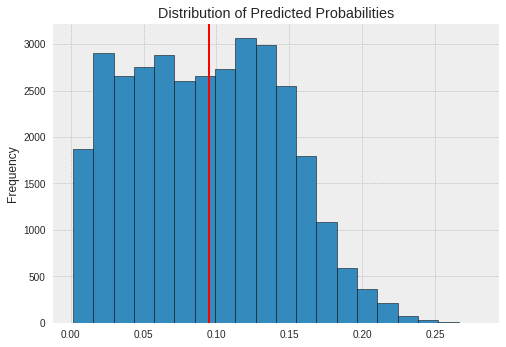

In [168]:
prediction_df['PROBABILITY'].plot.hist(bins=20, edgecolor='k')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.title('Distribution of Predicted Probabilities')

#Business Value Analysis

#Model Optimization

TPOT stands for Tree-based Pipeline Optimization Tool. Consider TPOT your Data Science Assistant. TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.
TPOT will automate the most tedious part of machine learning by intelligently exploring thousands of possible pipelines to find the best one for your data.


In [57]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3)

In [ ]:
pip install tpot

In [59]:
from tpot import TPOTClassifier

tpot_pipeline = TPOTClassifier(generations=10, population_size=10,
                               cv=tss, scoring='f1',
                               n_jobs=-1, verbosity=2,
                               random_state=50)

In [ ]:
tpot_pipeline.fit(train, y)

In [ ]:
tpot_pipeline.fitted_pipeline_

Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                        criterion='friedman_mse',
                                                                        init=None,
                                                                        learning_rate=1.0,
                                                                        loss='deviance',
                                                                        max_depth=3,
                                                                        max_features=0.8,
                                                                        max_leaf_nodes=None,
                                                                        min_impurity_decrease=0.0,
                                                                        min_impurity_split=None,
                            

# Other